# Klasyfikacja obiektów kosmicznych - Feature engineering
#### 0. Dane
#### 0.1. Pakiety

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#### 0.2. Podział danych na zbiór treningowy i testowy

In [31]:
# wczytanie danych
df = pd.read_csv('./data/development_data.csv')

# podział danych na zbiór treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# reset indeksów
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

## 1. Istotne informacje z etapu I (EDA)
### 1.1. Cel biznesowy
Celem biznesowym zadania jest klasyfikacja typów obiektów kosmicznych (zbudowanie modelu, który będzie klasyfikował typy obiektów kosmicznych).

### 1.2. Wnioski z EDA
- Klasa gwiazdy ma 3 możliwe wartości: STAR, GALAXY i QSO. Najpopularniejszą wartością jest więc GALAXY (59%), następnie QSO (22%) i STAR (19%). Dane nie są więc zbalansowane - w większości obserwacji klasą gwiazdy jest GALAXY.
- Kolumna spec_obj_ID ma bardzo duże znaczenie w zadaniu.
- Zmienne o nazwach [coś]_ID (z wyjątkiem sped_obj_ID) oraz cam_col nie mają znaczenia dla identyfikacji gwiazd.
-  <span style="color: yellow;">Zmienna redshift jest **bardzo istotna** przy określaniu klasy. Właściwie jednoznacznie określa klasę.</span>
- Zmienna u może pomóc określić, czy badany obiekt jest klasy QSO czy GALAXY (QSO ma dużo wartości u~=21, podczas gdy GALAXY ma ich bardzo mało).

Objaśnienie nazw zmiennych:
- spec_obj_ID = Unikalny identyfikator używany dla obiektów spektroskopii optycznej (oznacza to, że 2 różne obserwacje z tym samym identyfikatorem spec_obj_ID muszą dzielić klasę wyjściową)
- u = Filtr ultrafioletowy w systemie fotometrycznym
- redshift = wartość przesunięcia ku czerwieni oparta na wzroście długości fali

## 2. Znaczenie poszczególnych cech
### 2.1. Informacje o kolumnach
źródło: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?resource=download

- **obj_ID** = identyfikator obiektu, unikalna wartość identyfikująca obiekt w katalogu obrazów używanym przez CAS  
- **alpha** = kąt prawego wzniesienia (w epoce J2000)  
- **delta** = kąt deklinacji (w epoce J2000)  
- **u** = Filtr ultrafioletowy w systemie fotometrycznym  
- **g** = filtr zielony w systemie fotometrycznym  
- **r** = filtr czerwony w systemie fotometrycznym  
- **i** = Filtr bliskiej podczerwieni w systemie fotometrycznym  
- **z** = Filtr podczerwieni w systemie fotometrycznym  
- **run_ID** = numer przebiegu używany do identyfikacji konkretnego skanu  
- **rereun_ID** = numer ponownego uruchomienia określający sposób przetworzenia obrazu  
- **cam_col** = kolumna kamery do identyfikacji linii skanowania w przebiegu  
- **field_ID** = numer pola do identyfikacji każdego pola  
- **spec_obj_ID** = Unikalny identyfikator używany dla obiektów spektroskopii optycznej (oznacza to, że 2 różne obserwacje z tym samym identyfikatorem spec_obj_ID muszą dzielić klasę wyjściową)  
- <span style="color:blue">**class** = klasa obiektu (galaktyka, gwiazda lub kwazar)</span>  
- **redshift** = wartość przesunięcia ku czerwieni oparta na wzroście długości fali  
- **plate** = identyfikator tablicy, identyfikuje każdą tablicę w SDSS  
- **MJD** = zmodyfikowana data juliańska, używana do wskazania, kiedy dany fragment danych SDSS został pobrany  
- **fiber_ID** = identyfikator włókna identyfikujący włókno, które skierowało światło na płaszczyznę ogniskową w każdej obserwacji

### 2.2. Przydatne pojęcia kosmiczne
- 2.2.1. Celestial sphere: The celestial sphere is an imaginary sphere that has a large radius and is concentric on Earth. All objects in the sky can be conceived as being projected upon the inner surface of the celestial sphere, which may be centered on Earth or the observer.

- 2.2.2. Celestial equator: The celestial equator is the great circle of the imaginary celestial sphere on the same plane as the equator of Earth.

- 2.2.3. Ascension and declination: Ascension and declination both are used in astronomy and navigation in space. Ascension tells how far left or right the object is in the celestial sphere and declination tells how far up or down the object is in the celestial sphere.

- 2.2.4. Photometric system: The word photo means light and metry means measurement. So, measuring the brightness of the light which a human eye can perceive is called photometry. The UBV photometric system (from Ultraviolet, Blue, and Visual), also called the Johnson system, is a photometric system usually employed for classifying stars according to their colors. It was the first standardized photometric system.

- 2.2.5. Redshift: Redshift is a key concept for astronomers. The term can be understood literally — the wavelength of the light is stretched, so the light is seen as ‘shifted’ towards the red part of the spectrum. It reveals how an object in space (star/planet/galaxy) is moving compared to us. It lets astronomers measure the distance for the most distant (and therefore oldest) objects in our universe.

źródło: https://towardsdatascience.com/stellar-classification-a-machine-learning-approach-5e23eb5cadb1

### 2.3. Analiza cech 
Powyższe informacje o poszczególnych zmiennych połączymy z wiedzą zdobytą w procesie EDA i wyeliminujemy cechy niemające znaczenia przy identyfikacji klasy obiektu kosmicznego.

Dochodzimy do wniosku, że bez znaczenia są:
- **obj_ID** = identyfikator obiektu, unikalna wartość identyfikująca obiekt w katalogu obrazów używanym przez CAS;
- **run_ID** = numer przebiegu używany do identyfikacji konkretnego skanu;
- **rereun_ID** = numer ponownego uruchomienia określający sposób przetworzenia obrazu (ta sama wartość dla wszystkich instancji);
- **cam_col** = kolumna kamery do identyfikacji linii skanowania w przebiegu;
- **field_ID** = numer pola do identyfikacji każdego pola;
- **MJD** = zmodyfikowana data juliańska, używana do wskazania, kiedy dany fragment danych SDSS został pobrany;
- **fiber_ID** = identyfikator włókna identyfikujący włókno, które skierowało światło na płaszczyznę ogniskową w każdej obserwacji;
- **plate** = identyfikator tablicy, identyfikuje każdą tablicę w SDSS.

Zatem przydatne w ustalaniu klasy obiektu są:
- **alpha** = kąt prawego wzniesienia (w epoce J2000)  
- **delta** = kąt deklinacji (w epoce J2000)  
- **u** = Filtr ultrafioletowy w systemie fotometrycznym  
- **g** = filtr zielony w systemie fotometrycznym  
- **r** = filtr czerwony w systemie fotometrycznym  
- **i** = Filtr bliskiej podczerwieni w systemie fotometrycznym  
- **z** = Filtr podczerwieni w systemie fotometrycznym  
- **spec_obj_ID** = Unikalny identyfikator używany dla obiektów spektroskopii optycznej (oznacza to, że 2 różne obserwacje z tym samym identyfikatorem spec_obj_ID muszą dzielić klasę wyjściową)   
- **redshift** = wartość przesunięcia ku czerwieni oparta na wzroście długości fali  



In [32]:
# kolumny z waznymi cechami
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'spec_obj_ID', 'redshift']

# X - ramka danych ograniczona do interesujących nas cech
X = train_df[imp_cols]
y = train_df['class'].values

X_test = test_df[imp_cols]
y_test = test_df['class'].values


### 2.4. Rozkład obiektów na sferze niebieskiej

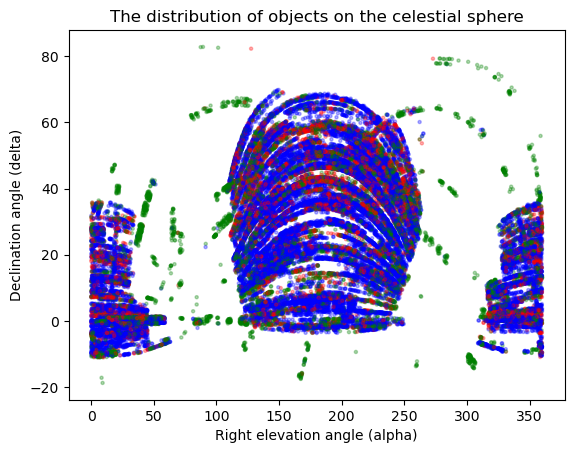

In [33]:
class_colors = {"QSO": "red", "GALAXY": "blue", "STAR": "green"}

plt.scatter(x = train_df["alpha"], y = train_df["delta"], s = 5, alpha = 0.3, c = train_df["class"].map(class_colors))

plt.title("The distribution of objects on the celestial sphere")
plt.xlabel("Right elevation angle (alpha)")
plt.ylabel("Declination angle (delta)")
plt.show()

Wykres ten można lepiej zrozumieć uwzględniając informację nr 2.2.3. z paragrafu 2.2. Przydatne pojęcia kosmiczne:

" 2.2.3. Ascension and declination: Ascension and declination both are used in astronomy and navigation in space. Ascension tells how far left or right the object is in the celestial sphere and declination tells how far up or down the object is in the celestial sphere."

## 3. Normalizacja

Skalowanie danych do zakresu [0; 1]. Dzięki temu zachowujemy proporcje między cechami i jednocześnie ograniczamy wpływ wartości odstających.

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
X = scaling.fit_transform(X)
X_test = scaling.transform(X_test)

##  Inżynieria cech
## 4. Feature importance
Sprawdzamy, czy zmienna redshift jednoznacznie wyznacza klasę obiektu kosmicznego.
### 4.1. Random Forest Classifier

Feature ranking:
1. Feature redshift (0.6645266697666725)
2. Feature z (0.09700775427299273)
3. Feature g (0.06262542492272952)
4. Feature i (0.062055616537353635)
5. Feature u (0.05567218816556349)
6. Feature spec_obj_ID (0.03446543552736725)
7. Feature r (0.021729454403647395)
8. Feature delta (0.0011434600187883348)
9. Feature alpha (0.0007739963848850892)


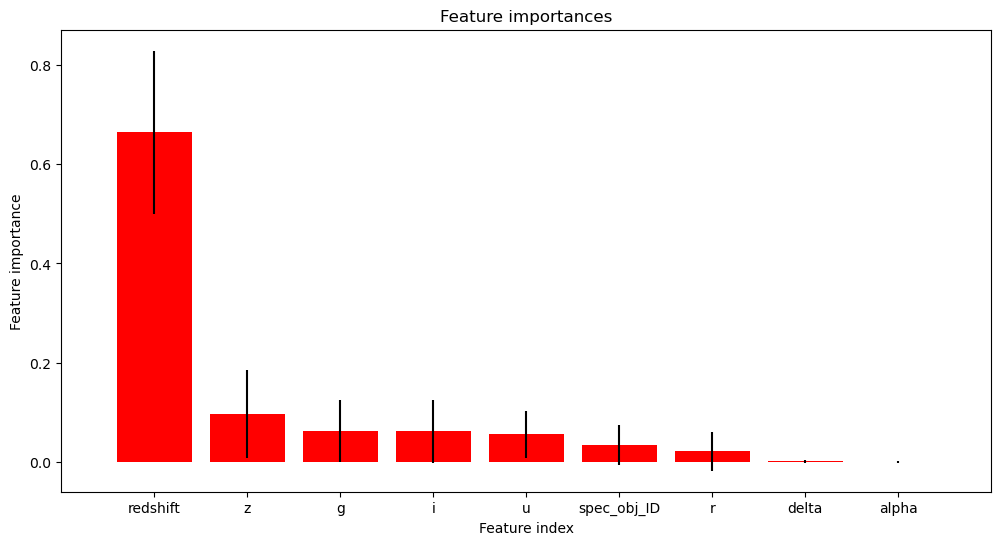

In [35]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {imp_cols[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [imp_cols[i] for i in indices])
plt.xlim([-1, X.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()


Wnioski:
- Wykorzystując model Random Forest Classifier, stwierdzamy, że wśród istniejących cech, **redshift** jest tą najważniejszą.
- Pozostałe cechy są mało istotne w porównaniu z **redshift**.
- Wcześniej podejrzewaliśmy, że **spec_obj_ID** będzie istotna, tak nie jest.


## 5. Nowe cechy
Stworzymy nowe cechy i sprawdzimy, czy ulepszą one nasz model. Część z nich (w szczególności 5.1. i 5.3. ma jakiś sens fizyczny).

Do oceny ważności cech wykorzystamy Random Forest Classifier.

### 5.1. Wskaźniki kolor-kolor
Tworzenie indeksów kolor-kolor poprzez łączenie pomiarów strumienia z różnych filtrów. 

Feature ranking:
1. Feature redshift (0.46810410823935344)
2. Feature g-r (0.11955431271352675)
3. Feature u-r (0.09937422055229893)
4. Feature i-z (0.08240855885731736)
5. Feature r-i (0.05412590090516194)
6. Feature u-g (0.03530567136865856)
7. Feature z (0.03172260878737483)
8. Feature g (0.030257446191165407)
9. Feature i (0.023699411125371054)
10. Feature spec_obj_ID (0.02215141867239212)
11. Feature r (0.016743699706941558)
12. Feature u (0.014261488423667977)
13. Feature alpha (0.0016581740139649172)
14. Feature delta (0.0006329804428051736)


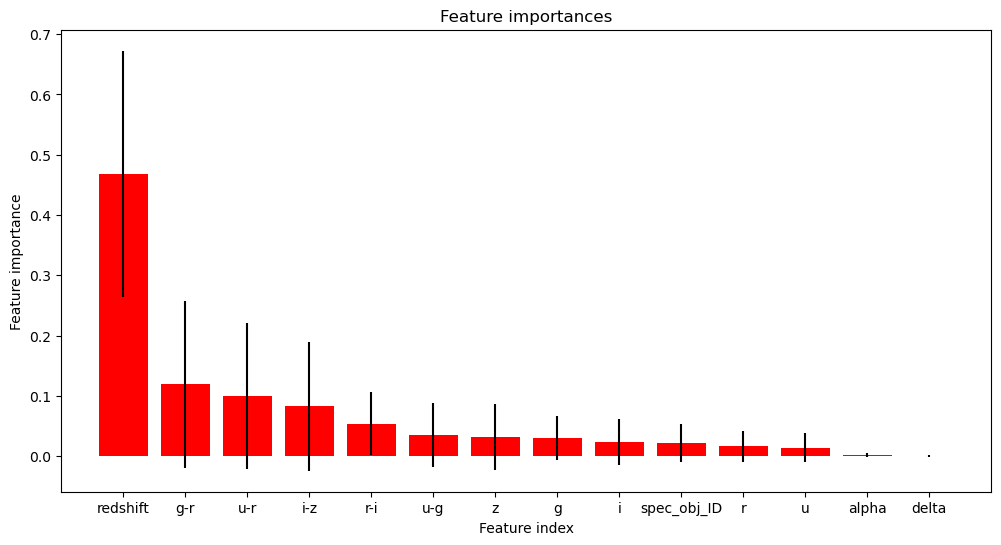

In [36]:
# generate new features in x: u-g, g-r, r-i, i-z, u-r
X = pd.DataFrame(X, columns=imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['u-g'] = X_['u'] - X_['g']
X_['g-r'] = X_['g'] - X_['r']
X_['r-i'] = X_['r'] - X_['i']
X_['i-z'] = X_['i'] - X_['z']
X_['u-r'] = X_['u'] - X_['r']

# add new features to the list of important columns
imp_cols_ = imp_cols + ['u-g', 'g-r', 'r-i', 'i-z', 'u-r']

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()



Wnioski:
- wszytskie cechy *kolor-kolor* okazały się być dużo istotniejsze niż pojedyncze wartości filtrów.
### 5.2. Zmodyfikowane alfa i delta
Rozmieszczenie obiektów na sferze niebieksiej (patrz: 2.4.) sugeruje, że pewien stosunek zmiennych alfa i delta może mieć znaczenie przy identyfikacji obiektu kosmicznego.

Feature ranking:
1. Feature redshift (0.6263076669241552)
2. Feature z (0.0969699837043785)
3. Feature i (0.06658043130813468)
4. Feature u (0.06174900282530152)
5. Feature g (0.056530130416694)
6. Feature spec_obj_ID (0.049339628949272754)
7. Feature r (0.03338087428759584)
8. Feature alpha*delta (0.0030459836801495967)
9. Feature delta (0.0018620516559690915)
10. Feature alpha (0.0018019176891797052)
11. Feature alpha+delta (0.0017971329737993195)
12. Feature alpha-delta (0.0006351955853697411)


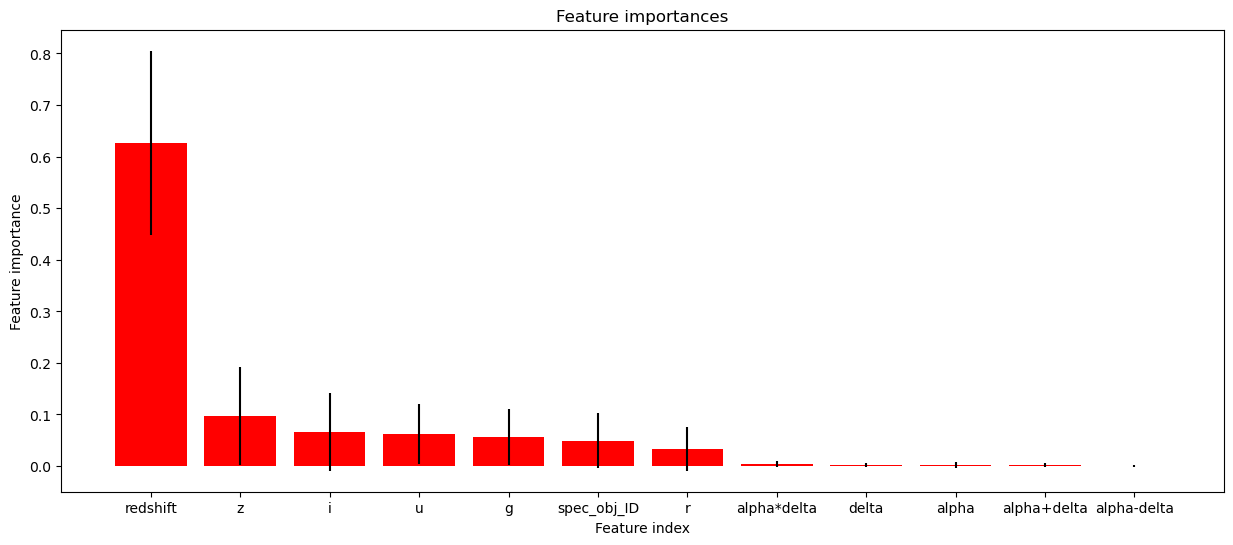

In [37]:
# generate new features in X: alpha-delta, alpha+delta, alpha*delta
X = pd.DataFrame(X, columns=imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['alpha-delta'] = X_['alpha'] - X_['delta']
X_['alpha+delta'] = X_['alpha'] + X_['delta']
# X_['alpha/delta'] = X_['alpha'] / X_['delta'] # --- nie działa, bo się tworzą NaNy
X_['alpha*delta'] = X_['alpha'] * X_['delta']

# add new features to the list of important columns
imp_cols_ = imp_cols + ['alpha-delta', 'alpha+delta', 'alpha*delta']


# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(15, 6))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

Wnioski:
- Alfa i delta same w sobie mówią dużo więcej o klasie docelowej niż ich suma czy różnica.
- Iloczyn nic ważnego nie wprowadza do modelu.
- Inne dziłania matematyczne, mające sens, przeprowadzone na zmiennych alfa i delta wymagałyby zaawansowanej wiedzy astronomicznej, której nie posiadamy. 

### 5.3. Współczynniki wielkości
Obliczymy wybrane współczynniki magnitudo poprzez logarytmowanie współczynników strumienia. 
**Współczynniki magnitudo są powszechnie stosowane w astronomii do ilościowego określania jasności obiektów.**

Feature ranking:
1. Feature redshift (0.5146812024350961)
2. Feature ri_mr (0.1758826747640198)
3. Feature iz_mr (0.08753911636081334)
4. Feature ug_mr (0.05155550476424633)
5. Feature z (0.04839066745228258)
6. Feature i (0.028115979559603196)
7. Feature g (0.02718957663491839)
8. Feature u (0.02708160653775044)
9. Feature r (0.020011078969251927)
10. Feature spec_obj_ID (0.018147981657372685)
11. Feature delta (0.0008632567323324226)
12. Feature alpha (0.0005413541323128981)


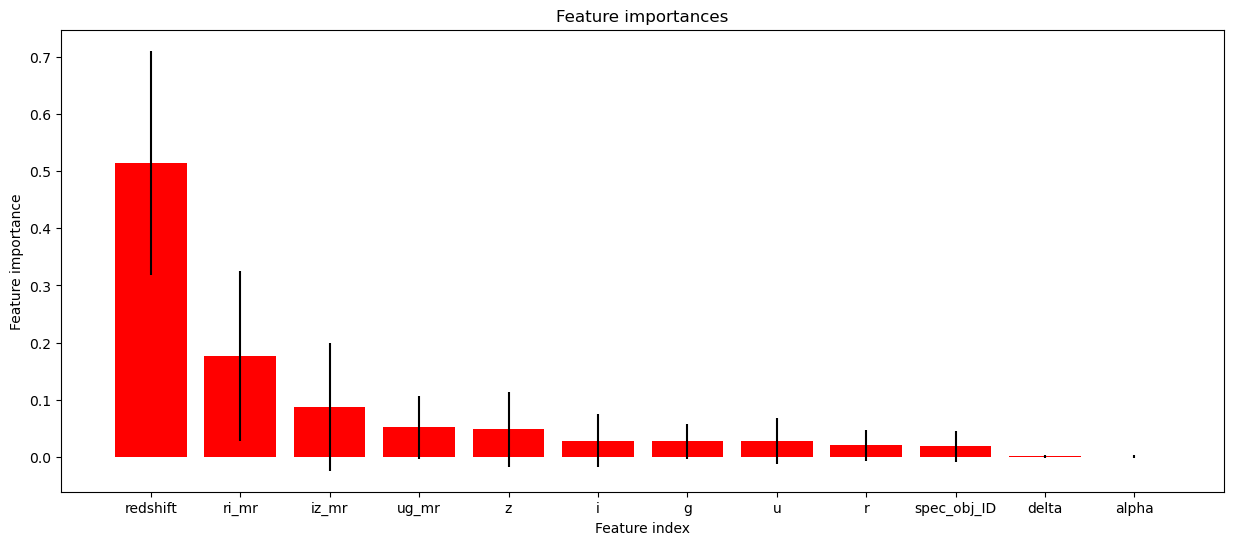

In [38]:
# generate new features in ug_mr, gr_mr, ri_mr, iz_mr
X = pd.DataFrame(X, columns=imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['ug_mr'] = np.log(X_['u'] / X_['g'])
# X_['gr_mr'] = np.log(X_['g'] / X_['r']) # --- nie działa, bo się tworzą nieskonczonosci
X_['ri_mr'] = np.log(X_['r'] / X_['i'])
X_['iz_mr'] = np.log(X_['i'] / X_['z'])

# add new features to the list of important columns
imp_cols_ = imp_cols + ['ug_mr', 'ri_mr', 'iz_mr']

# change NaNs to median value --- there is only one NaN in each column
median_ug_mr = X_['ug_mr'].median()
X_['ug_mr'] = X_['ug_mr'].fillna(median_ug_mr)

median_r_i = X_['ri_mr'].median()
X_['ri_mr'] = X_['ri_mr'].fillna(median_r_i)

median_iz_mr = X_['iz_mr'].median()
X_['iz_mr'] = X_['iz_mr'].fillna(median_iz_mr)


# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(15, 6))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

Uwagi:
- W nowych cechach pojawiły się wartości NaN, zastąpiono je medianą.
- Nie jest to inwazyjne działanie, bo na 49000 rekordów, dotyczy tylko jednego.

Wnioski:
- Maginute ratios pokazują dużo więcej niż podstawowe filtry.

### 5.4. Kombinacja redshift z innymi cechami
Redshift jest cechą dominującą, więc sprawdzimy, czy kombinacje tej cechy z innymi cechami mogą poprawić wydajność modelu.

Redshift i alpha

Feature ranking:
1. Feature redshift (0.48680031615940245)
2. Feature redshift*alpha (0.2670445068396984)
3. Feature z (0.06145763595598565)
4. Feature u (0.03973009267082188)
5. Feature i (0.0325449488901552)
6. Feature g (0.029160853462727395)
7. Feature redshift-alpha (0.02229619706474385)
8. Feature spec_obj_ID (0.02061899464227332)
9. Feature r (0.017351894887876234)
10. Feature redshift+aplha (0.01683436487297986)
11. Feature alpha (0.004854545267099154)
12. Feature delta (0.001305649286236508)


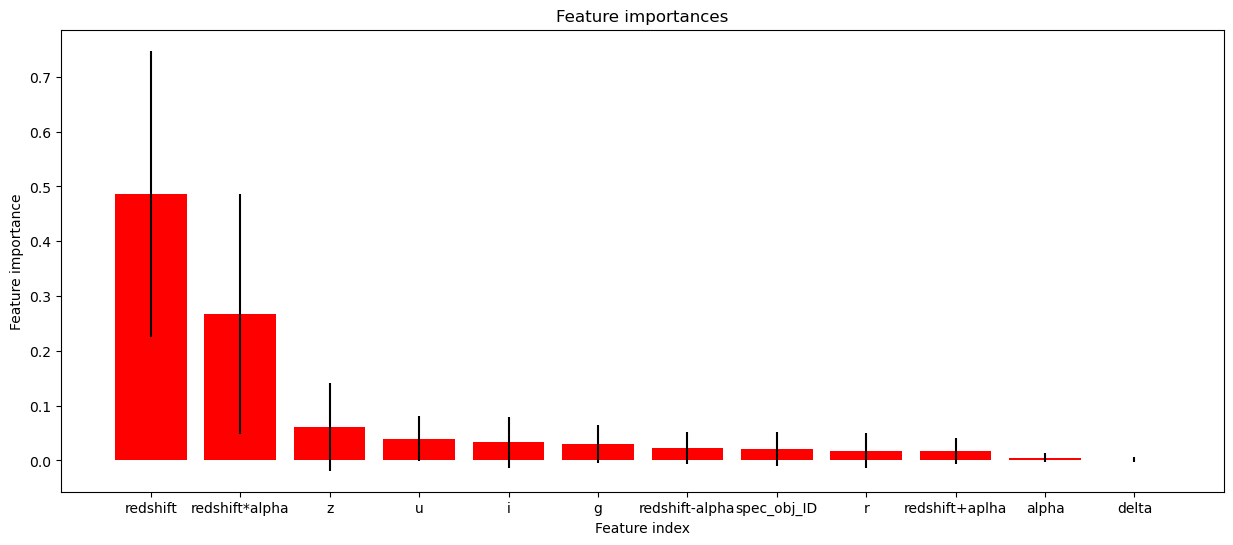

In [39]:
# generate new features in X: redshift-alpha, redshift+alpha, redshift*alpha, redshift/alpha
X = pd.DataFrame(X, columns = imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['redshift-alpha'] = X_['redshift'] - X_['alpha']
X_['redshift+alpha'] = X_['redshift'] + X_['alpha']
X_['redshift*alpha'] = X_['redshift'] * X_['alpha']
# X_['redshift/alpha'] = X_['redshift'] / X_['alpha'] # --- nie działa, bo się tworzą nieskonczonosci

# add new features to the list of important columns
imp_cols_ = imp_cols + ['redshift-alpha', 'redshift+aplha', 'redshift*alpha']

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(15, 6))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()


- Redshift*alpha moze wpływać pozytywnie na model.
- Pozostałe kolumny: redshift-alpha i redshift+alpha okazały się nieznaczące.

Redshift i delta

Feature ranking:
1. Feature redshift (0.4680677948607323)
2. Feature redshift*delta (0.3011447385936645)
3. Feature z (0.05308519341551013)
4. Feature redshift-delta (0.041506822866920104)
5. Feature u (0.035041555780672216)
6. Feature i (0.025927029443349296)
7. Feature redshift+delta (0.02508387380338615)
8. Feature g (0.020929176602707333)
9. Feature spec_obj_ID (0.01684202806785614)
10. Feature r (0.010568486113165713)
11. Feature delta (0.001410319574293886)
12. Feature alpha (0.0003929808777422061)


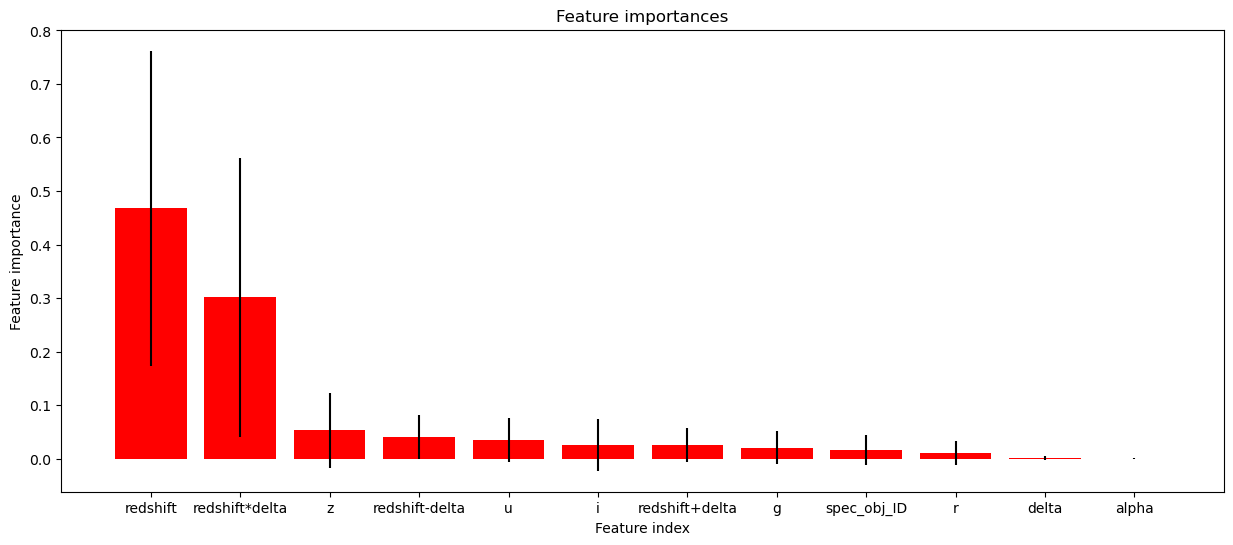

In [40]:
# generate new features in X: redshift-delta, redshift+delta, redshift*delta, redshift/delta
X = pd.DataFrame(X, columns = imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['redshift-delta'] = X_['redshift'] - X_['delta']
X_['redshift+delta'] = X_['redshift'] + X_['delta']
X_['redshift*delta'] = X_['redshift'] * X_['delta']
# X_['redshift/delta'] = X_['redshift'] / X_['delta'] # --- nie działa, bo się tworzą nieskonczonosci

# add new features to the list of important columns
imp_cols_ = imp_cols + ['redshift-delta', 'redshift+delta', 'redshift*delta']

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(15, 6))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()


- Redshift*delta moze wpływać pozytywnie na model.
- Pozostałe kolumny: redshift-delta i redshift+delta okazały się nieznaczące.

Redshift i z, u, i, g, r

Feature ranking:
1. Feature redshift (0.17708254721089958)
2. Feature rs*i (0.16370847594855728)
3. Feature rs*r (0.16024630938463139)
4. Feature rs*z (0.12946910970527206)
5. Feature rs*g (0.09498790210103142)
6. Feature rs*u (0.0903757449311691)
7. Feature rs+z (0.0339718125888406)
8. Feature rs-u (0.03096716286741565)
9. Feature rs+i (0.02440392891003203)
10. Feature rs-g (0.02355651549963886)
11. Feature rs+r (0.015502766468199768)
12. Feature rs-r (0.014833891945144435)
13. Feature rs+g (0.009080035954172866)
14. Feature g (0.008583294658403066)
15. Feature rs-i (0.006823879252332879)
16. Feature u (0.003868995718685856)
17. Feature r (0.0036207882720181083)
18. Feature rs-z (0.0028458210809173944)
19. Feature z (0.0025998463204870096)
20. Feature rs+u (0.0019768734929882185)
21. Feature i (0.001494297689162569)


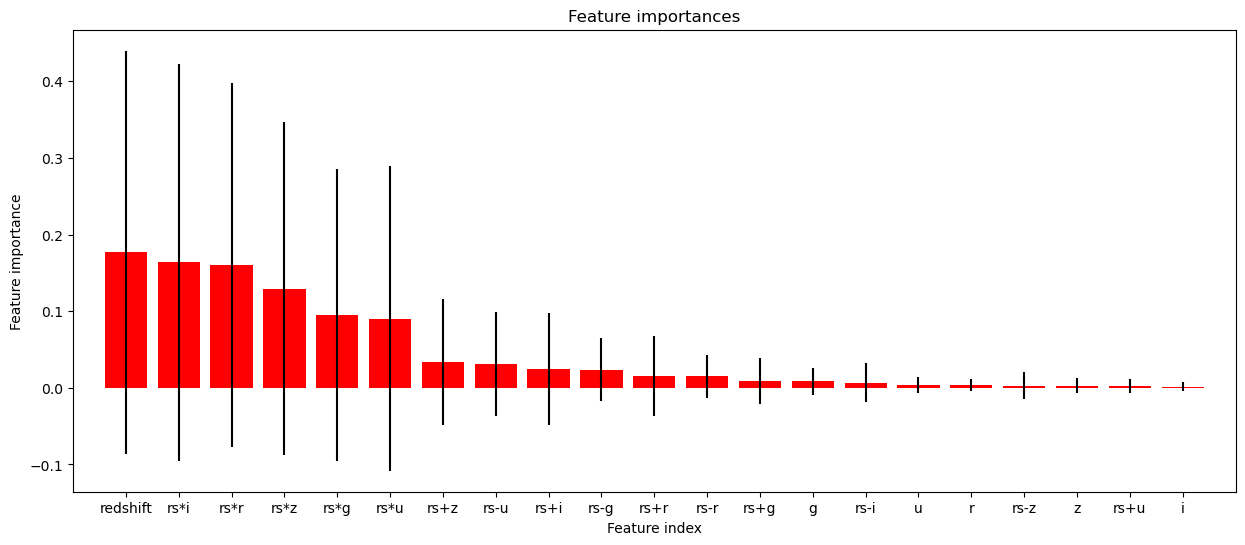

In [50]:
# generate new features in X: redshift-z, redshift+z, redshift*z, redshift-u, redshift+u, redshift*u, redshift-i, redshift+i, redshift*i, redshift-g, redshift+g, redshift*g, redshift-r, redshift+r, redshift*r
X = pd.DataFrame(X, columns = imp_cols)

# copy X for testing purposes
X_ = X.copy()
exclude_cols = ['spec_obj_ID', 'alpha', 'delta', 'alpha']   # nie potrzebuje tych kolumn do tej wizualizacji, a tylko psuja przejrzystość wykresu
X_ = X_.drop(exclude_cols, axis=1)

# add new features
# redshift and z
X_['rs-z'] = X_['redshift'] - X_['z']
X_['rs+z'] = X_['redshift'] + X_['z']
X_['rs*z'] = X_['redshift'] * X_['z']
# X_['redshift/z'] = X_['redshift'] / X_['z'] # --- nie działa, bo się tworzą nieskonczonosci

# redshift and u
X_['rs-u'] = X_['redshift'] - X_['u']
X_['rs+u'] = X_['redshift'] + X_['u']
X_['rs*u'] = X_['redshift'] * X_['u']

# redshift and i
X_['rs-i'] = X_['redshift'] - X_['i']
X_['rs+i'] = X_['redshift'] + X_['i']
X_['rs*i'] = X_['redshift'] * X_['i']

# redshift and g
X_['rs-g'] = X_['redshift'] - X_['g']
X_['rs+g'] = X_['redshift'] + X_['g']
X_['rs*g'] = X_['redshift'] * X_['g']

# redshift and r
X_['rs-r'] = X_['redshift'] - X_['r']
X_['rs+r'] = X_['redshift'] + X_['r']
X_['rs*r'] = X_['redshift'] * X_['r']

# add new features to the list of important columns
imp_cols_ = [col for col in imp_cols if col not in exclude_cols] + ['rs-z', 'rs+z', 'rs*z', 'rs-u', 'rs+u', 'rs*u', 'rs-i', 'rs+i', 'rs*i', 'rs-g', 'rs+g', 'rs*g', 'rs-r', 'rs+r', 'rs*r']

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(15, 6))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

- Iloczyny redshift z filtrami mogą być przydatne w naszym modelowaniu.
- Pozostałe kombinacje nie są znaczące.

### 5.4. Podsumowanie i wybranie cech do modelu

Przeanalizujmy te cechy, które są istotniejsze od tych już istniejących.

## GASPI

Feature ranking:
1. Feature redshift (0.4495571735359382)
2. Feature ri_mr (0.13254258574318298)
3. Feature g-r (0.09701784848937481)
4. Feature iz_mr (0.06983282992470993)
5. Feature u-r (0.06720007558823553)
6. Feature i-z (0.04365867905747776)
7. Feature r-i (0.03311546431753257)
8. Feature u-g (0.022163698093565044)
9. Feature z (0.020094197527958504)
10. Feature i (0.017405204411224794)
11. Feature g (0.014195708668332562)
12. Feature spec_obj_ID (0.01055534564942468)
13. Feature r (0.009173593565830453)
14. Feature ug_mr (0.00828725982564021)
15. Feature u (0.004464725217635982)
16. Feature alpha (0.0004875481243563388)
17. Feature delta (0.00024806225957977023)


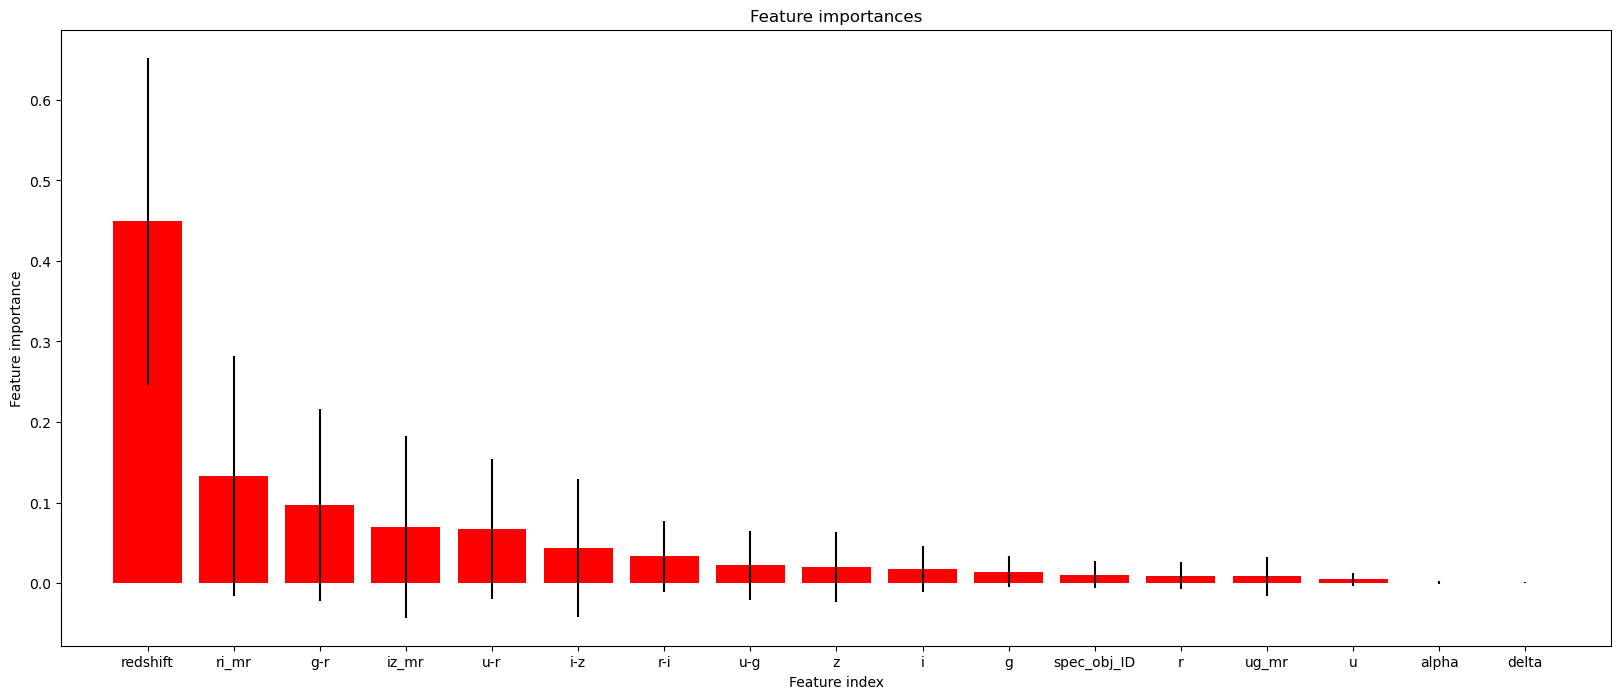

In [52]:
X = pd.DataFrame(X, columns=imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['u-g'] = X_['u'] - X_['g']
X_['g-r'] = X_['g'] - X_['r']
X_['r-i'] = X_['r'] - X_['i']
X_['i-z'] = X_['i'] - X_['z']
X_['u-r'] = X_['u'] - X_['r']
X_['ug_mr'] = np.log(X_['u'] / X_['g'])
X_['ri_mr'] = np.log(X_['r'] / X_['i'])
X_['iz_mr'] = np.log(X_['i'] / X_['z'])

# add new features to the list of important columns
imp_cols_ = imp_cols + ['u-g', 'g-r', 'r-i', 'i-z', 'u-r', 'ug_mr', 'ri_mr', 'iz_mr']

# change NaNs to median value --- there is only one NaN in each column
median_ug_mr = X_['ug_mr'].median()
X_['ug_mr'] = X_['ug_mr'].fillna(median_ug_mr)

median_r_i = X_['ri_mr'].median()
X_['ri_mr'] = X_['ri_mr'].fillna(median_r_i)

median_iz_mr = X_['iz_mr'].median()
X_['iz_mr'] = X_['iz_mr'].fillna(median_iz_mr)


# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

Wnioski:
- **Redshift** bezsprzecznie pozostaje najważniejszą cechą w naszym modelu.
- Zmienne magnitude ratio **ri_mr** i **iz_mr** mają duże znaczenie dla modelu.
- Wszystkie zmienne kolor-kolor są istotne.

Wobec tego stwierdzamy, że cechy:
- alpha
- delta
- spec_obj_ID
- r
- ug_mr
- u

mogą być pominięte w naszym modelu.

## NADIA

Feature ranking:
1. Feature redshift (0.19182345174644133)
2. Feature rs*i (0.16484819304435055)
3. Feature rs*z (0.1461277790003896)
4. Feature rs*r (0.08126056899826901)
5. Feature rs*g (0.07631252763364525)
6. Feature rs*u (0.06510610793399438)
7. Feature rs*delta (0.06161750929598804)
8. Feature ri_mr (0.053774118204229004)
9. Feature rs*alpha (0.04455121516600511)
10. Feature g-r (0.027496450255646905)
11. Feature u-r (0.02029475607278812)
12. Feature iz_mr (0.01759030297097116)
13. Feature g (0.007951781173826859)
14. Feature i-z (0.006947134137987214)
15. Feature z (0.0065293526944527865)
16. Feature r-i (0.005829339514861743)
17. Feature ug_mr (0.005163994008668258)
18. Feature r (0.0050727331584986025)
19. Feature u (0.0039373625952613765)
20. Feature u-g (0.003861523561666794)
21. Feature i (0.002052357923539533)
22. Feature spec_obj_ID (0.0014222424349871034)
23. Feature alpha (0.0003818386774909142)
24. Feature delta (4.735979604045256e-05)


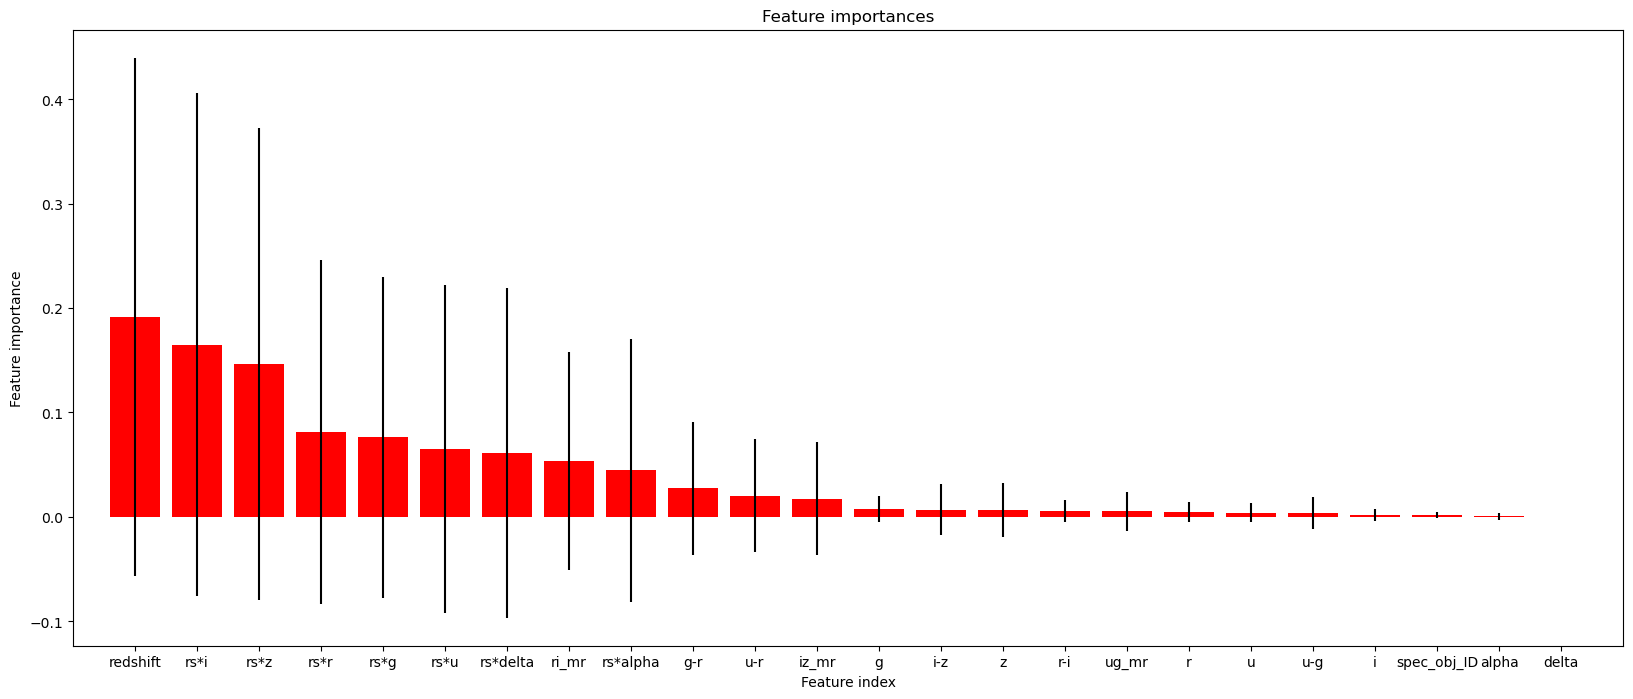

In [53]:
X = pd.DataFrame(X, columns=imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['u-g'] = X_['u'] - X_['g']
X_['g-r'] = X_['g'] - X_['r']
X_['r-i'] = X_['r'] - X_['i']
X_['i-z'] = X_['i'] - X_['z']
X_['u-r'] = X_['u'] - X_['r']
X_['ug_mr'] = np.log(X_['u'] / X_['g'])
X_['ri_mr'] = np.log(X_['r'] / X_['i'])
X_['iz_mr'] = np.log(X_['i'] / X_['z'])
X_['rs*alpha'] = X_['redshift'] * X_['alpha']
X_['rs*delta'] = X_['redshift'] * X_['delta']
X_['rs*z'] = X_['redshift'] * X_['z']
X_['rs*u'] = X_['redshift'] * X_['u']
X_['rs*i'] = X_['redshift'] * X_['i']
X_['rs*g'] = X_['redshift'] * X_['g']
X_['rs*r'] = X_['redshift'] * X_['r']

# add new features to the list of important columns
imp_cols_ = imp_cols + ['u-g', 'g-r', 'r-i', 'i-z', 'u-r', 'ug_mr', 'ri_mr', 'iz_mr', 'rs*alpha', 'rs*delta', 'rs*z', 'rs*u', 'rs*i', 'rs*g', 'rs*r']

# change NaNs to median value --- there is only one NaN in each column
median_ug_mr = X_['ug_mr'].median()
X_['ug_mr'] = X_['ug_mr'].fillna(median_ug_mr)

median_r_i = X_['ri_mr'].median()
X_['ri_mr'] = X_['ri_mr'].fillna(median_r_i)

median_iz_mr = X_['iz_mr'].median()
X_['iz_mr'] = X_['iz_mr'].fillna(median_iz_mr)


# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

Wnioski:
- **Redshift** bezsprzecznie pozostaje najważniejszą cechą w naszym modelu.
- Te zmienne, które są kombinacjami z redshift: **redshift * i**, **redshift * z**, **redshift * g**, **redshift * u**, **redshift * alpha**, **redshift * delta** mają duże znaczenie dla modelu.
- Zmienne magnitude ratio **ri_mr** i **iz_mr** mają również spore znaczenie dla modelu.
- Wszystkie zmienne kolor-kolor są istotne.

Wobec tego stwierdzamy, że cechy:
- alpha
- delta
- spec_obj_ID
- r
- ug_mr
- u

mogą być pominięte w naszym modelu.

## Modelowanie
### 1. Dokładaność algorytmów
Będziemy badać różne algorytmy. Definiujemy funkcję *score* obliczającą dokładność algorytmów.

In [8]:
def score(model, title = ""):
    model.fit(X, y)
    predicts = model.predict(X_test)

    # confusion matrix
    cm = confusion_matrix(y_test, predicts)
    print(f"{title} confusion matrix:")
    print(cm)

    fig = px.imshow(confusion_matrix(y_test, predicts),text_auto='.2f',
                    title = 'Heatmap of Confusion matrix')
    fig.show()

    accuracy = round(accuracy_score(y_test, predicts), 4)
    print(f"{title} accuracy: {accuracy}")

    return accuracy

### 1.1. Regresja logistyczna

In [9]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=101, solver='lbfgs', multi_class='multinomial',max_iter=10000)
lg_score = score(lg, "Logistic Regression") 


c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Logistic Regression confusion matrix:
[[11902   208   428]
 [  495  3465    13]
 [  414     0  4075]]


Logistic Regression accuracy: 0.9258


### 1.2. Random Forest

In [10]:
# random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_score = score(rf, "Random Forest")

c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Random Forest confusion matrix:
[[12223   202   113]
 [  450  3522     1]
 [    3     0  4486]]


Random Forest accuracy: 0.9634


### 1.3. Naive Bayes 

In [11]:
# naive bayes gaussianNB
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb_score = score(nb, "Naive Bayes GaussianNB")

Naive Bayes GaussianNB confusion matrix:
[[11162  1267   109]
 [  452  3520     1]
 [   21    23  4445]]


c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



Naive Bayes GaussianNB accuracy: 0.9108


### 1.4. K Neighbors Classifier

In [12]:
# knn
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn_score = score(knn, "KNN")

c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



KNN confusion matrix:
[[12092   129   317]
 [  339  3588    46]
 [  571     8  3910]]


KNN accuracy: 0.9329


### 1.5. Drzewa decyzyjne

In [13]:
# decision tree
dt = DecisionTreeClassifier(criterion='gini')
dt_score = score(dt, "Decision Tree")

NameError: name 'DecisionTreeClassifier' is not defined

### 1.6. Drzewa decyzyjne: Gini

In [ ]:
# gini
gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
gini_score = score(gini, "Gini")

Gini confusion matrix:
[[12247   200    91]
 [  502  3470     1]
 [    7     0  4482]]


Gini accuracy: 0.9619


### 1.7. Drzewa decyzyjne: entropia

In [ ]:
# entropy
entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
entropy_score = score(entropy, "Entropy")

Entropy confusion matrix:
[[12248   200    90]
 [  499  3473     1]
 [    5     0  4484]]


Entropy accuracy: 0.9621


### 1.8. SVC

In [ ]:
# svc
# from sklearn.svm import SVC
# svc_ = SVC(kernel='rbf', random_state=42)
# svc_score = score(svc_, "SVC")

### 1.9. Podsumowanie

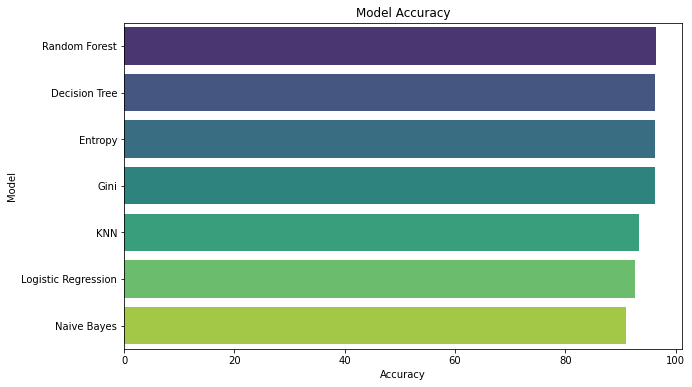

In [ ]:
x = {'Score' : [lg_score, rf_score, nb_score, knn_score, dt_score, gini_score, entropy_score]}
df = pd.DataFrame(x)
df['Score'] = df['Score'] * 100
df['Model'] = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'KNN', 'Decision Tree', 'Gini', 'Entropy']
df = df.sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Model', data=df, palette='viridis')
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


Powyższy wykres pokazuje dokładność modeli. Najdokłądniejszym jest Random Forest zaraz obok Decision Tree, Decision Tree: Entropy oraz Decision Tree: Gini.  